# Title of notebook

Brief 1-2 sentence description of notebook.

# Summary

- Experiment
    - Observing fighting behavior between mice in their home cage in different settings. Mice are categorized as winner and loser based on if they initiated the behavior or if they are recieving it. Recording sessions are usually from 30 minutes to a hour with cages of 2 to 6 mice.
- Data
    - Excel spreadsheet of recorded fighting behavior. The relevant columns are those of the "Date" of the recording, the "winner" of the interaction, and the "loser" of the interaction. Each row will be for one interaction between two mice.
    - There is a cage for each sheet of the spreadsheet
    - For each recording session, we will assume that the date will be specified for that first row. We will use this to seperate all the rows into seperate sessions.
- Purpose of this Jupyter Notebook
    - To calculate the Elo Score of each mice after each interaction. The mice start off with an Elo score of 1000. Elo scores are calculated with the formula from here: https://www.omnicalculator.com/sports/elo . Then we will plot the change of elo score across all interactions. With the number of interactions on the X-Axis and the current Elo score on the Y. There will be a line for mice.

In [1]:
import copy
import re
import os
import sys
import string
import glob
import ast
from collections import Counter
from collections import defaultdict
import warnings

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import git
# Getting the path of the root directory so that we can import repo specific functions
git_repo_object = git.Repo('.', search_parent_directories=True)
git_repo_directory = git_repo_object.working_tree_dir

In [4]:
# Setting path so that we can import functions
sys.path.append(os.path.join(git_repo_directory, "src"))

In [5]:
os.path.join(git_repo_directory, "src")


'/nancy/projects/social_dominance_active_inference/src'

In [6]:
from elorating import calculation
from elorating import dataframe

In [7]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Inputs & Data

Explanation of each input and where it comes from.

In [8]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"/root/work/" # where data is saved should always be shown in the inputs

## Inputs & Data

Explanation of each input and where it comes from.

In [9]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs

In [10]:
PROTOCOL_NAME = "tube_test"
PREFIX_NAME = "tt"
RAW_DATA_FILE_PATH = "../../data/pilot_3/pilot_3_tube_test.xlsx"
ALL_HEADER_ROW = 1
CAGE_TO_STRAIN = {"1": "C57", "2": "C57", "3": "C57", "4": "CD1", "5": "CD1", "6": "CD1"}

RAW_DATA_SHEET_NAMES = ['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

In [11]:
"RAW_DATA_SHEET_NAMES".upper()

'RAW_DATA_SHEET_NAMES'

In [12]:
WINNER_ID_COLUMN = "winner"
LOSER_ID_COLUMN = "loser"
ALL_SESSION_DIVIDER_COLUMN = "date"
CAGE_NUM_OF_WINNER_COLUMN = "sheet_name"
CAGE_NUM_OF_LOSER_COLUMN = "sheet_name"

In [13]:
ELO_RATING_SPREADSHEET_OUTPUT_DIRECTORY = os.path.join(OUTPUT_DIR, "elo_rating_spread_sheets")

In [14]:
os.makedirs(ELO_RATING_SPREADSHEET_OUTPUT_DIRECTORY, exist_ok=True)

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [15]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names



In [16]:
# SCORING_DF = pd.read_excel(RAW_DATA_FILE_PATH, sheet_name=INPUTTED_SHEET_NAME, header=ALL_HEADER_ROW)

In [17]:
# Going through each sheet and creating a dataframe of it
sheet_name_to_everything = defaultdict(dict)
for sheet in RAW_DATA_SHEET_NAMES:
    sheet_name_to_everything[sheet]["SCORING_DF"] = pd.read_excel(RAW_DATA_FILE_PATH, sheet_name=sheet, header=ALL_HEADER_ROW)

## Standarizing the Columns

- Making all the column names lower case and removing any extra spaces in the beginning and at the end
    - One dictionary per sheet

In [18]:
for key, value in sheet_name_to_everything.items():
    # Creating a dictionary that maps the original column name to the standarized one
    column_name_to_standarized = defaultdict(dict)
    for col in value["SCORING_DF"]:
        # Making the column name lower case and removing the spaces
        column_name_to_standarized[col] = "_".join(str(col).lower().strip().split(" "))
    value["column_name_to_standarized"] = column_name_to_standarized

In [19]:
value["column_name_to_standarized"]

defaultdict(dict,
            {'runner': 'runner',
             'date': 'date',
             'match': 'match',
             'winner': 'winner',
             'loser': 'loser',
             'notes': 'notes'})

In [20]:
# Renaming all the columns to the lower case and space removed version
for key, value in sheet_name_to_everything.items():
    value["processed_behavior_recording_dataframe"] = value["SCORING_DF"].rename(columns=value["column_name_to_standarized"])
    value["processed_behavior_recording_dataframe"]["sheet_name"] = key

In [21]:
value["processed_behavior_recording_dataframe"].head()

,runner,date,match,winner,loser,notes,sheet_name
0,Jocelyn,2022-09-06 00:00:00,6.1vs6.2,6.1,6.2,NaN,CAGE6
1,NaN,NaN,6.2vs6.3,6.2,6.3,NaN,CAGE6
2,NaN,NaN,6.3vs6.4,6.3,6.4,NaN,CAGE6
3,NaN,NaN,6.4vs6.2,6.2,6.4,NaN,CAGE6
4,NaN,NaN,6.1vs6.3,6.3,6.1,NaN,CAGE6


## Dropping All Rows without a Winner

- Because we will be filling all empty cells with the previous value, we must remove all rows that don't have any data. This is usually cells that don't have any winners or losers filled in the row.
    

# **NOTE**: If there is a set column that is used for the winner and loser,  the rows up by session, then enter it in the cell below between the quotation marks. Default is `"winner"` and `"loser"`

In [22]:
for key, value in sheet_name_to_everything.items():
    # Dropping all rows that don't have any values in the winner column
    value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].dropna(subset=WINNER_ID_COLUMN)
    
    # Dropping all rows that don't have any values in the loser column
    value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].dropna(subset=LOSER_ID_COLUMN)
    
    # Getting all the floats from the strings, removing any spaces and other characters
    value["processed_behavior_recording_dataframe"][WINNER_ID_COLUMN] = value["processed_behavior_recording_dataframe"][WINNER_ID_COLUMN].astype(str).apply(lambda x: re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)[0] if re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x) else x)
    
    value["processed_behavior_recording_dataframe"][LOSER_ID_COLUMN] = value["processed_behavior_recording_dataframe"][LOSER_ID_COLUMN].astype(str).apply(lambda x: re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)[0] if re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x) else x)

## Adding the session number

- We are adding the session number to all the trials. The session number is counting the number of recording sessions that have happened up until that trial. Usually, each session in the spreadsheet is divided up by a session's first row having the date filled in. So we will label a new session when a date is filled in.

# NOTE: If there is a set column that divides the rows up by session, then enter it in the cell below between the quotation marks. Default is `"date"`

In [23]:
for key, value in sheet_name_to_everything.items():
    current_processed_behavior_recording_dataframe = value["processed_behavior_recording_dataframe"].copy()
    value["processed_behavior_recording_dataframe"][ALL_SESSION_DIVIDER_COLUMN] = value["processed_behavior_recording_dataframe"][ALL_SESSION_DIVIDER_COLUMN].fillna(method='ffill')



/tmp/ipykernel_1623808/3697261599.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value["processed_behavior_recording_dataframe"][ALL_SESSION_DIVIDER_COLUMN] = value["processed_behavior_recording_dataframe"][ALL_SESSION_DIVIDER_COLUMN].fillna(method='ffill')


In [24]:
value["processed_behavior_recording_dataframe"].head()

,runner,date,match,winner,loser,notes,sheet_name
0,Jocelyn,2022-09-06,6.1vs6.2,6.1,6.2,NaN,CAGE6
1,NaN,2022-09-06,6.2vs6.3,6.2,6.3,NaN,CAGE6
2,NaN,2022-09-06,6.3vs6.4,6.3,6.4,NaN,CAGE6
3,NaN,2022-09-06,6.4vs6.2,6.2,6.4,NaN,CAGE6
4,NaN,2022-09-06,6.1vs6.3,6.3,6.1,NaN,CAGE6


# Getting the Session number differences

- Getting the indexes of where each new session starts. So that we can add the session number to each row.

In [25]:
for key, value in sheet_name_to_everything.items():

    # Filling all the empty cells with the value in the previous cell
    value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].fillna(method='ffill')

    value["processed_behavior_recording_dataframe"]["session_number_difference"] = value["processed_behavior_recording_dataframe"][ALL_SESSION_DIVIDER_COLUMN].astype('category').cat.codes.diff()


/tmp/ipykernel_1623808/4232331498.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].fillna(method='ffill')
/tmp/ipykernel_1623808/4232331498.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].fillna(method='ffill')
/tmp/ipykernel_1623808/4232331498.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  value["processed_behavior_recording_dataframe"] = value["processed_behavior_recording_dataframe"].fillna(method='ffill')
/tmp/ipykernel_1623808/4232331498.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and

In [26]:
value["processed_behavior_recording_dataframe"].head(n=15)

,runner,date,match,winner,loser,notes,sheet_name,session_number_difference
0,Jocelyn,2022-09-06,6.1vs6.2,6.1,6.2,NaN,CAGE6,NaN
1,Jocelyn,2022-09-06,6.2vs6.3,6.2,6.3,NaN,CAGE6,0.0
2,Jocelyn,2022-09-06,6.3vs6.4,6.3,6.4,NaN,CAGE6,0.0
3,Jocelyn,2022-09-06,6.4vs6.2,6.2,6.4,NaN,CAGE6,0.0
4,Jocelyn,2022-09-06,6.1vs6.3,6.3,6.1,NaN,CAGE6,0.0
5,Jocelyn,2022-09-06,6.4vs6.1,6.1,6.4,NaN,CAGE6,0.0
6,Meghan,2022-09-07,6.3vs6.2,6.3,6.2,NaN,CAGE6,1.0
7,Meghan,2022-09-07,6.4vs6.1,6.1,6.4,NaN,CAGE6,0.0
8,Meghan,2022-09-07,6.2vs6.4,6.2,6.4,NaN,CAGE6,0.0
9,Meghan,2022-09-07,6.1vs6.3,6.1,6.3,NaN,CAGE6,0.0


In [27]:
value["processed_behavior_recording_dataframe"].tail(n=15)

,runner,date,match,winner,loser,notes,sheet_name,session_number_difference
33,Jocelyn,2022-09-13,6.4vs6.2,6.2,6.4,NaN,CAGE6,0.0
34,Jocelyn,2022-09-13,6.1vs6.3,6.1,6.3,NaN,CAGE6,0.0
35,Jocelyn,2022-09-13,6.4vs6.1,6.1,6.4,NaN,CAGE6,0.0
36,Meghan,2022-09-15,6.3vs6.2,6.3,6.2,NaN,CAGE6,1.0
37,Meghan,2022-09-15,6.4vs6.1,6.1,6.4,NaN,CAGE6,0.0
38,Meghan,2022-09-15,6.2vs6.4,6.2,6.4,NaN,CAGE6,0.0
39,Meghan,2022-09-15,6.1vs6.3,6.1,6.3,NaN,CAGE6,0.0
40,Meghan,2022-09-15,6.3vs6.4,6.3,6.4,NaN,CAGE6,0.0
41,Meghan,2022-09-15,6.1vs6.2,6.2,6.1,NaN,CAGE6,0.0
42,Meghan,2022-09-27,6.4vs6.3,6.3,6.4,NaN,CAGE6,1.0


## Getting the cage number

- The cage number is sometimes not consistent throughout a spreadsheet for the same cage. So we will try to standarize it into one value.
    - **NOTE**: This assumes cage numbers are actual numbers. And not entirely consisting of letters. If that isn't the case, then you must edit this cell for your needs.

# NOTE: If there is a column that has the cage number information, replace the `None` with the column name in quotation marks

- Change this when you have id to cage

In [28]:
sheet_name_to_everything['CAGE2']["processed_behavior_recording_dataframe"]

,runner,date,match,winner,loser,notes,sheet_name,session_number_difference
0,Jocelyn,2022-09-06,2.1vs2.2,2.1,2.2,NaN,CAGE2,NaN
1,Jocelyn,2022-09-06,2.2vs2.3,2.3,2.2,NaN,CAGE2,0.0
2,Jocelyn,2022-09-06,2.3vs2.4,2.3,2.4,NaN,CAGE2,0.0
3,Jocelyn,2022-09-06,2.4vs2.2,2.2,2.4,NaN,CAGE2,0.0
4,Jocelyn,2022-09-06,2.1vs2.3,2.1,2.3,NaN,CAGE2,0.0
5,Jocelyn,2022-09-06,2.4vs2.1,2.1,2.4,NaN,CAGE2,0.0
6,Meghan,2022-09-07,2.3vs2.2,2.3,2.2,NaN,CAGE2,1.0
7,Meghan,2022-09-07,2.4vs2.1,2.1,2.4,NaN,CAGE2,0.0
8,Meghan,2022-09-07,2.2vs2.4,2.2,2.4,NaN,CAGE2,0.0
9,Meghan,2022-09-07,2.1vs2.3,2.1,2.3,NaN,CAGE2,0.0


## Calculating Elo rating

- Example calculation

In [29]:
calculation.calculate_elo_rating(subject_elo_rating=1000, agent_elo_rating=2000, score=1)

1019.9

In [30]:
calculation.update_elo_rating(winner_id="A", loser_id="B")

defaultdict(<function elorating.calculation.update_elo_rating.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

## Get the Elo rating for all the events

- Going through each row or interaction and calculating the new Elo rating for the winner and loser. This will create a new dataframe based off of the processed behavioral recording dataframe

# NOTE: If there are a set of columns to keep, edit the cell below with the name of the columns each in quotation marks seperated by commas
   - i.e. `['runner', 'date', 'match', 'winner', 'loser', 'notes', 'session_number',
       'session_number_difference']`

In [31]:
all_columns_to_keep = None

In [32]:
for key, value in sheet_name_to_everything.items():
    # Calculating the Elo rating    
    value["index_to_elo_rating_and_meta_data"] = calculation.iterate_elo_rating_calculation_for_dataframe(dataframe=value["processed_behavior_recording_dataframe"], winner_id_column=WINNER_ID_COLUMN, loser_id_column=LOSER_ID_COLUMN, additional_columns=value["processed_behavior_recording_dataframe"].columns)

     # Making a dataframe from the dictionary 
    value["elo_rating_dataframe"] = pd.DataFrame.from_dict(value["index_to_elo_rating_and_meta_data"], orient="index")

    value["elo_rating_dataframe"]["cage_#"] = re.findall(r'\d+', key)[0]


In [33]:
value["elo_rating_dataframe"].head()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,cage_#
0,1,6.1,6.2,1000.0,1010.0,1,1,2,0,Jocelyn,2022-09-06,6.1vs6.2,6.1,6.2,NaN,CAGE6,NaN,6
1,1,6.2,6.1,1000.0,990.0,0,2,1,1,Jocelyn,2022-09-06,6.1vs6.2,6.1,6.2,NaN,CAGE6,NaN,6
2,2,6.2,6.3,990.0,1000.3,1,2,3,0,Jocelyn,2022-09-06,6.2vs6.3,6.2,6.3,NaN,CAGE6,0.0,6
3,2,6.3,6.2,1000.0,989.7,0,3,2,1,Jocelyn,2022-09-06,6.2vs6.3,6.2,6.3,NaN,CAGE6,0.0,6
4,3,6.3,6.4,989.7,1000.0,1,3,4,0,Jocelyn,2022-09-06,6.3vs6.4,6.3,6.4,NaN,CAGE6,0.0,6


In [34]:
value["elo_rating_dataframe"].tail()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,cage_#
91,46,6.4,6.1,843.1,839.8,0,4,1,1,Meghan,2022-09-27,6.1vs6.4,6.1,6.4,NaN,CAGE6,0.0,6
92,47,6.2,6.4,1015.9,1021.2,1,2,4,0,Meghan,2022-09-27,6.4vs6.2,6.2,6.4,NaN,CAGE6,0.0,6
93,47,6.4,6.2,839.8,834.5,0,4,2,1,Meghan,2022-09-27,6.4vs6.2,6.2,6.4,NaN,CAGE6,0.0,6
94,48,6.1,6.3,1131.0,1137.7,1,1,3,0,Meghan,2022-09-27,6.3vs6.1,6.1,6.3,NaN,CAGE6,0.0,6
95,48,6.3,6.1,1013.3,1006.6,0,3,1,1,Meghan,2022-09-27,6.3vs6.1,6.1,6.3,NaN,CAGE6,0.0,6


In [35]:
value["elo_rating_dataframe"].groupby("subject_id").count()

,total_match_number,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,cage_#
subject_id,,,,,,,,,,,,,,,,,
6.1,24,24,24,24,24,24,24,24,24,24,24,24,24,0,24,23,24
6.2,24,24,24,24,24,24,24,24,24,24,24,24,24,0,24,23,24
6.3,24,24,24,24,24,24,24,24,24,24,24,24,24,0,24,24,24
6.4,24,24,24,24,24,24,24,24,24,24,24,24,24,0,24,24,24


## Combining all the Elo rating dataframes into one

In [36]:
# Putting all the dataframes into one list
all_sheet_elo_scord_dataframe_list = []
for key, value in sheet_name_to_everything.items():    
    all_sheet_elo_scord_dataframe_list.append(value["elo_rating_dataframe"])

# Combining all the dataframes into one
all_sheet_elo_scord_dataframe_combined = pd.concat(all_sheet_elo_scord_dataframe_list)

In [37]:
all_sheet_elo_scord_dataframe_combined.head()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,cage_#
0,1,1.1,1.2,1000.0,1010.0,1,1,2,0,Jocelyn,2022-09-06,1.1vs1.2,1.1,1.2,NaN,CAGE1,NaN,1
1,1,1.2,1.1,1000.0,990.0,0,2,1,1,Jocelyn,2022-09-06,1.1vs1.2,1.1,1.2,NaN,CAGE1,NaN,1
2,2,1.2,1.3,990.0,1000.3,1,2,3,0,Jocelyn,2022-09-06,1.2vs1.3,1.2,1.3,NaN,CAGE1,0.0,1
3,2,1.3,1.2,1000.0,989.7,0,3,2,1,Jocelyn,2022-09-06,1.2vs1.3,1.2,1.3,NaN,CAGE1,0.0,1
4,3,1.4,1.3,1000.0,1009.7,1,2,4,0,Jocelyn,2022-09-06,1.3vs1.4,1.4,1.3,NaN,CAGE1,0.0,1


- Adding the strain information

In [38]:
all_subject_ids = set(all_sheet_elo_scord_dataframe_combined["subject_id"].unique()).union(set(all_sheet_elo_scord_dataframe_combined["agent_id"].unique()))

# NOTE: If there are strains that are associated to each cage, then create a dictionary of cage numbers to strains inside the `{}`
- i.e. `CAGE_TO_STRAIN = {"1": "C57", "2": "C57", "3": "C57", "4": "CD1", "5": "CD1", "6": "CD1"}`

In [39]:
all_sheet_elo_scord_dataframe_combined["strain"] = all_sheet_elo_scord_dataframe_combined["cage_#"].map(CAGE_TO_STRAIN)

- Adding the name of the experiment

In [40]:
# Adding the name of the experiment
all_sheet_elo_scord_dataframe_combined["experiment_type"] = PROTOCOL_NAME

In [41]:
all_sheet_elo_scord_dataframe_combined.head()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,cage_#,strain,experiment_type
0,1,1.1,1.2,1000.0,1010.0,1,1,2,0,Jocelyn,2022-09-06,1.1vs1.2,1.1,1.2,NaN,CAGE1,NaN,1,C57,tube_test
1,1,1.2,1.1,1000.0,990.0,0,2,1,1,Jocelyn,2022-09-06,1.1vs1.2,1.1,1.2,NaN,CAGE1,NaN,1,C57,tube_test
2,2,1.2,1.3,990.0,1000.3,1,2,3,0,Jocelyn,2022-09-06,1.2vs1.3,1.2,1.3,NaN,CAGE1,0.0,1,C57,tube_test
3,2,1.3,1.2,1000.0,989.7,0,3,2,1,Jocelyn,2022-09-06,1.2vs1.3,1.2,1.3,NaN,CAGE1,0.0,1,C57,tube_test
4,3,1.4,1.3,1000.0,1009.7,1,2,4,0,Jocelyn,2022-09-06,1.3vs1.4,1.4,1.3,NaN,CAGE1,0.0,1,C57,tube_test


In [42]:
all_sheet_elo_scord_dataframe_combined.tail()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,cage_#,strain,experiment_type
91,46,6.4,6.1,843.1,839.8,0,4,1,1,Meghan,2022-09-27,6.1vs6.4,6.1,6.4,NaN,CAGE6,0.0,6,CD1,tube_test
92,47,6.2,6.4,1015.9,1021.2,1,2,4,0,Meghan,2022-09-27,6.4vs6.2,6.2,6.4,NaN,CAGE6,0.0,6,CD1,tube_test
93,47,6.4,6.2,839.8,834.5,0,4,2,1,Meghan,2022-09-27,6.4vs6.2,6.2,6.4,NaN,CAGE6,0.0,6,CD1,tube_test
94,48,6.1,6.3,1131.0,1137.7,1,1,3,0,Meghan,2022-09-27,6.3vs6.1,6.1,6.3,NaN,CAGE6,0.0,6,CD1,tube_test
95,48,6.3,6.1,1013.3,1006.6,0,3,1,1,Meghan,2022-09-27,6.3vs6.1,6.1,6.3,NaN,CAGE6,0.0,6,CD1,tube_test


In [43]:
# Checking to see how many rows for each subject in each cage
all_sheet_elo_scord_dataframe_combined.groupby(['subject_id','cage_#']).count()

,,total_match_number,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,strain,experiment_type
subject_id,cage_#,,,,,,,,,,,,,,,,,,
1.1,1,24,24,24,24,24,24,24,24,24,24,24,24,24,23,24,23,24,24
1.2,1,24,24,24,24,24,24,24,24,24,24,24,24,24,22,24,23,24,24
1.3,1,24,24,24,24,24,24,24,24,24,24,24,24,24,22,24,24,24,24
1.4,1,24,24,24,24,24,24,24,24,24,24,24,24,24,23,24,24,24,24
2.1,2,24,24,24,24,24,24,24,24,24,24,24,24,24,0,24,23,24,24
2.2,2,24,24,24,24,24,24,24,24,24,24,24,24,24,0,24,23,24,24
2.3,2,24,24,24,24,24,24,24,24,24,24,24,24,24,0,24,24,24,24
2.4,2,24,24,24,24,24,24,24,24,24,24,24,24,24,0,24,24,24,24
3.1,3,24,24,24,24,24,24,24,24,24,24,24,24,24,0,24,23,24,24


## Creating a dataframe with only the final Elo rating for each subject

In [44]:
# Checking to see which cage and subject combination has more than one row
all_sheet_elo_scord_dataframe_groupby = all_sheet_elo_scord_dataframe_combined.groupby(['subject_id','cage_#']).size().reset_index()
all_sheet_elo_scord_dataframe_groupby = all_sheet_elo_scord_dataframe_groupby[all_sheet_elo_scord_dataframe_groupby[0] >= 1]

# Going through each combination and saving the combination to a dictionary
index_to_subject_id_and_processed_cage_number = defaultdict(dict)
for index, row in all_sheet_elo_scord_dataframe_groupby.iterrows():
    index_to_subject_id_and_processed_cage_number[index]['subject_id'] = row['subject_id']
    index_to_subject_id_and_processed_cage_number[index]['cage_#'] = row['cage_#']


In [45]:
index_to_subject_id_and_processed_cage_number

defaultdict(dict,
            {0: {'subject_id': '1.1', 'cage_#': '1'},
             1: {'subject_id': '1.2', 'cage_#': '1'},
             2: {'subject_id': '1.3', 'cage_#': '1'},
             3: {'subject_id': '1.4', 'cage_#': '1'},
             4: {'subject_id': '2.1', 'cage_#': '2'},
             5: {'subject_id': '2.2', 'cage_#': '2'},
             6: {'subject_id': '2.3', 'cage_#': '2'},
             7: {'subject_id': '2.4', 'cage_#': '2'},
             8: {'subject_id': '3.1', 'cage_#': '3'},
             9: {'subject_id': '3.2', 'cage_#': '3'},
             10: {'subject_id': '3.3', 'cage_#': '3'},
             11: {'subject_id': '3.4', 'cage_#': '3'},
             12: {'subject_id': '4.1', 'cage_#': '4'},
             13: {'subject_id': '4.2', 'cage_#': '4'},
             14: {'subject_id': '4.3', 'cage_#': '4'},
             15: {'subject_id': '4.4', 'cage_#': '4'},
             16: {'subject_id': '5.1', 'cage_#': '5'},
             17: {'subject_id': '5.2', 'cage_#': '5'},
  

- Getting the final Elo rating for each cage and subject combination

In [46]:
for index, (key, value) in enumerate(index_to_subject_id_and_processed_cage_number.items()):   
    # The Elo rating dataframe for each cage and subject combination
    per_subject_dataframe = all_sheet_elo_scord_dataframe_combined[(all_sheet_elo_scord_dataframe_combined["subject_id"] == value["subject_id"]) & (all_sheet_elo_scord_dataframe_combined["cage_#"] == value["cage_#"])]
    # Getting the final Elo rating for each combination
    # -1 Means that we're getting the data from the last row

    index_to_subject_id_and_processed_cage_number[index]["final_elo_rating"] = per_subject_dataframe.iloc[-1]["updated_elo_rating"]
    
    index_to_subject_id_and_processed_cage_number[index]["strain"] = per_subject_dataframe.iloc[-1]["strain"]



In [47]:
id_to_final_elo_rating_df = pd.DataFrame.from_dict(index_to_subject_id_and_processed_cage_number, orient="index")
# Adding protocol name
id_to_final_elo_rating_df["experiment_type"] = PROTOCOL_NAME
# Adding rank
id_to_final_elo_rating_df["rank"] = id_to_final_elo_rating_df.groupby("cage_#")["final_elo_rating"].rank("dense", ascending=False)
# Sorting by cage and then id
id_to_final_elo_rating_df = id_to_final_elo_rating_df.sort_values(by=['cage_#', "subject_id"], ascending=True).reset_index(drop=True)

In [48]:
id_to_final_elo_rating_df.head()

,subject_id,cage_#,final_elo_rating,strain,experiment_type,rank
0,1.1,1,1165.3,C57,tube_test,1.0
1,1.2,1,1054.5,C57,tube_test,2.0
2,1.3,1,882.3,C57,tube_test,4.0
3,1.4,1,897.9,C57,tube_test,3.0
4,2.1,2,1127.8,C57,tube_test,1.0


In [49]:
id_to_final_elo_rating_df.tail()

,subject_id,cage_#,final_elo_rating,strain,experiment_type,rank
19,5.4,5,1165.3,CD1,tube_test,1.0
20,6.1,6,1137.7,CD1,tube_test,1.0
21,6.2,6,1021.2,CD1,tube_test,2.0
22,6.3,6,1006.6,CD1,tube_test,3.0
23,6.4,6,834.5,CD1,tube_test,4.0


# Making plots for all sheets

- Getting the dates the files were being recorded to use for the file name

In [50]:
all_sheet_elo_scord_dataframe_combined.head()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,cage_#,strain,experiment_type
0,1,1.1,1.2,1000.0,1010.0,1,1,2,0,Jocelyn,2022-09-06,1.1vs1.2,1.1,1.2,NaN,CAGE1,NaN,1,C57,tube_test
1,1,1.2,1.1,1000.0,990.0,0,2,1,1,Jocelyn,2022-09-06,1.1vs1.2,1.1,1.2,NaN,CAGE1,NaN,1,C57,tube_test
2,2,1.2,1.3,990.0,1000.3,1,2,3,0,Jocelyn,2022-09-06,1.2vs1.3,1.2,1.3,NaN,CAGE1,0.0,1,C57,tube_test
3,2,1.3,1.2,1000.0,989.7,0,3,2,1,Jocelyn,2022-09-06,1.2vs1.3,1.2,1.3,NaN,CAGE1,0.0,1,C57,tube_test
4,3,1.4,1.3,1000.0,1009.7,1,2,4,0,Jocelyn,2022-09-06,1.3vs1.4,1.4,1.3,NaN,CAGE1,0.0,1,C57,tube_test


In [51]:
all_sheet_elo_scord_dataframe_combined.tail()

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,cage_#,strain,experiment_type
91,46,6.4,6.1,843.1,839.8,0,4,1,1,Meghan,2022-09-27,6.1vs6.4,6.1,6.4,NaN,CAGE6,0.0,6,CD1,tube_test
92,47,6.2,6.4,1015.9,1021.2,1,2,4,0,Meghan,2022-09-27,6.4vs6.2,6.2,6.4,NaN,CAGE6,0.0,6,CD1,tube_test
93,47,6.4,6.2,839.8,834.5,0,4,2,1,Meghan,2022-09-27,6.4vs6.2,6.2,6.4,NaN,CAGE6,0.0,6,CD1,tube_test
94,48,6.1,6.3,1131.0,1137.7,1,1,3,0,Meghan,2022-09-27,6.3vs6.1,6.1,6.3,NaN,CAGE6,0.0,6,CD1,tube_test
95,48,6.3,6.1,1013.3,1006.6,0,3,1,1,Meghan,2022-09-27,6.3vs6.1,6.1,6.3,NaN,CAGE6,0.0,6,CD1,tube_test


- Getting the earliest and the latest dates for all the recordings

In [52]:
all_earlist_dates = []
all_latest_dates = []
for key, value in sheet_name_to_everything.items():
    try:
        # Getting all the earliest dates for each sheet
        all_earlist_dates.append(value["elo_rating_dataframe"][ALL_SESSION_DIVIDER_COLUMN].min())
        all_latest_dates.append(value["elo_rating_dataframe"][ALL_SESSION_DIVIDER_COLUMN].max())
    except:
        print("WARNING: {} does not have dates as columns".format(key))
        warnings.warn("Look at warning from above or below")

In [53]:
value["elo_rating_dataframe"]

,total_match_number,subject_id,agent_id,original_elo_rating,updated_elo_rating,win_draw_loss,subject_ranking,agent_ranking,pairing_index,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,cage_#
0,1,6.1,6.2,1000.0,1010.0,1,1,2,0,Jocelyn,2022-09-06,6.1vs6.2,6.1,6.2,NaN,CAGE6,NaN,6
1,1,6.2,6.1,1000.0,990.0,0,2,1,1,Jocelyn,2022-09-06,6.1vs6.2,6.1,6.2,NaN,CAGE6,NaN,6
2,2,6.2,6.3,990.0,1000.3,1,2,3,0,Jocelyn,2022-09-06,6.2vs6.3,6.2,6.3,NaN,CAGE6,0.0,6
3,2,6.3,6.2,1000.0,989.7,0,3,2,1,Jocelyn,2022-09-06,6.2vs6.3,6.2,6.3,NaN,CAGE6,0.0,6
4,3,6.3,6.4,989.7,1000.0,1,3,4,0,Jocelyn,2022-09-06,6.3vs6.4,6.3,6.4,NaN,CAGE6,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,46,6.4,6.1,843.1,839.8,0,4,1,1,Meghan,2022-09-27,6.1vs6.4,6.1,6.4,NaN,CAGE6,0.0,6
92,47,6.2,6.4,1015.9,1021.2,1,2,4,0,Meghan,2022-09-27,6.4vs6.2,6.2,6.4,NaN,CAGE6,0.0,6
93,47,6.4,6.2,839.8,834.5,0,4,2,1,Meghan,2022-09-27,6.4vs6.2,6.2,6.4,NaN,CAGE6,0.0,6
94,48,6.1,6.3,1131.0,1137.7,1,1,3,0,Meghan,2022-09-27,6.3vs6.1,6.1,6.3,NaN,CAGE6,0.0,6


In [54]:
try:
    # Turning the Dates into a easier to read format
    # Getting the 0th part of split to remove seconds
    earliest_date = str(min(all_earlist_dates)).split()[0]
    latest_date = str(max(all_latest_dates)).split()[0]
    print("Earlist date: {}".format(earliest_date))
    print("Latest date: {}".format(latest_date))
except:
    earliest_date = None
    latest_date = None

Earlist date: 2022-09-06
Latest date: 2022-09-27


- Getting the cage numbers

In [55]:
all_cages_list = []
# Creating a list of all the cage numbers
for key, value in sheet_name_to_everything.items():
    try:
        for cage in value["elo_rating_dataframe"]["cage_#"].unique():
            all_cages_list.append(cage)
    except:
        print("WARNING: {} does not have cage number as columns".format(key))
        warnings.warn("Look at warning from above or below")

In [56]:
try:
    all_cages_string = "-".join(sorted([sheet.lower().strip("cage").strip() for sheet in all_cages_list]))
    all_cages_string = "cages-{}".format(all_cages_string)
    print("String of cage names to use for file name: {}".format(all_cages_string))
except: 
    warnings.warn("WARNING: There are no cage numbers to make a title out of")
    all_cages_string = None

String of cage names to use for file name: cages-1-2-3-4-5-6


- Creating an output directory to save the plots

In [57]:
plot_output_directory = os.path.join(".", "proc", "plots", "{}_elo_rating".format(PROTOCOL_NAME))

In [58]:
plot_output_directory

'./proc/plots/tube_test_elo_rating'

In [59]:
os.makedirs(plot_output_directory, exist_ok=True)

# **NOTE**: Sometimes this cell needs to be run again to make sure the size is correct

CAGE1


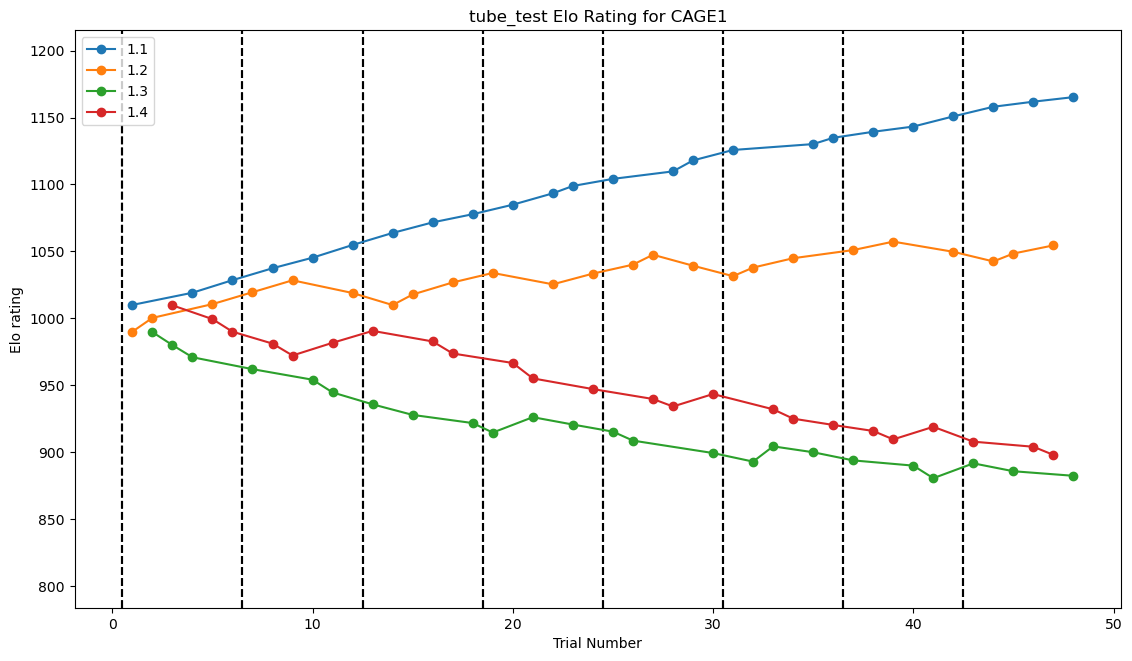

CAGE2


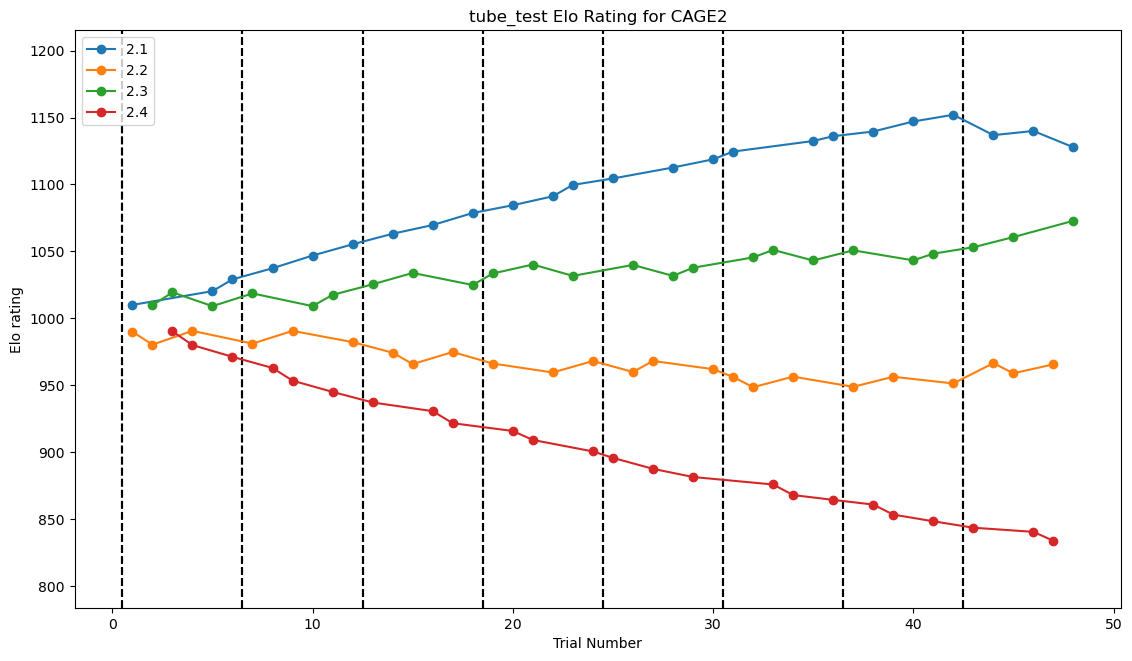

CAGE3


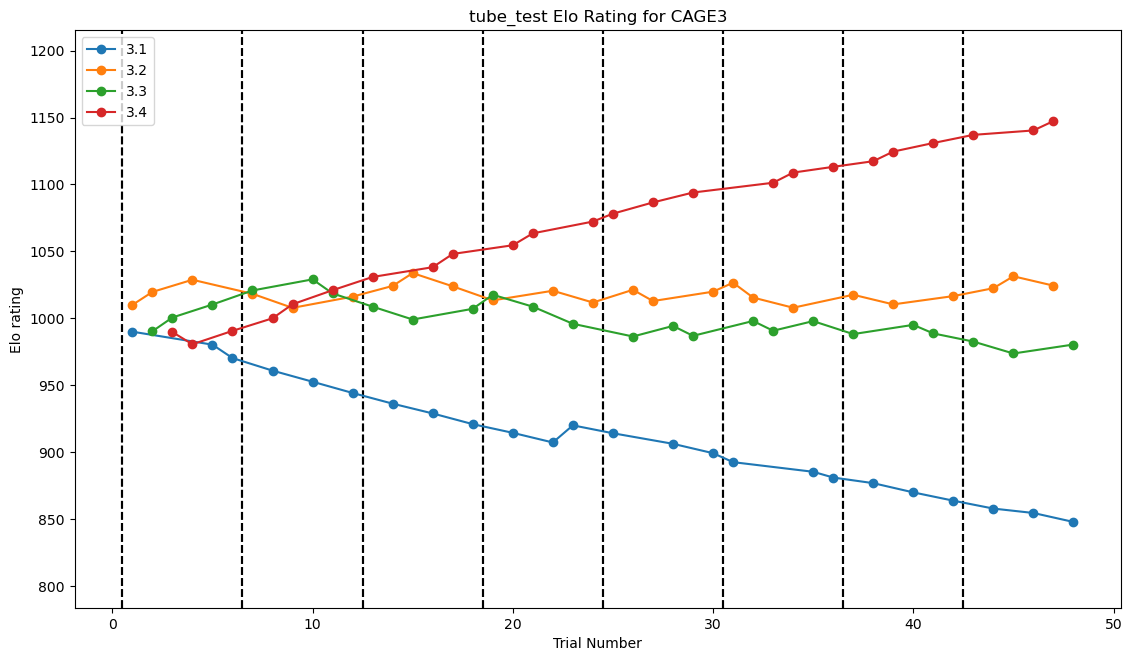

CAGE4


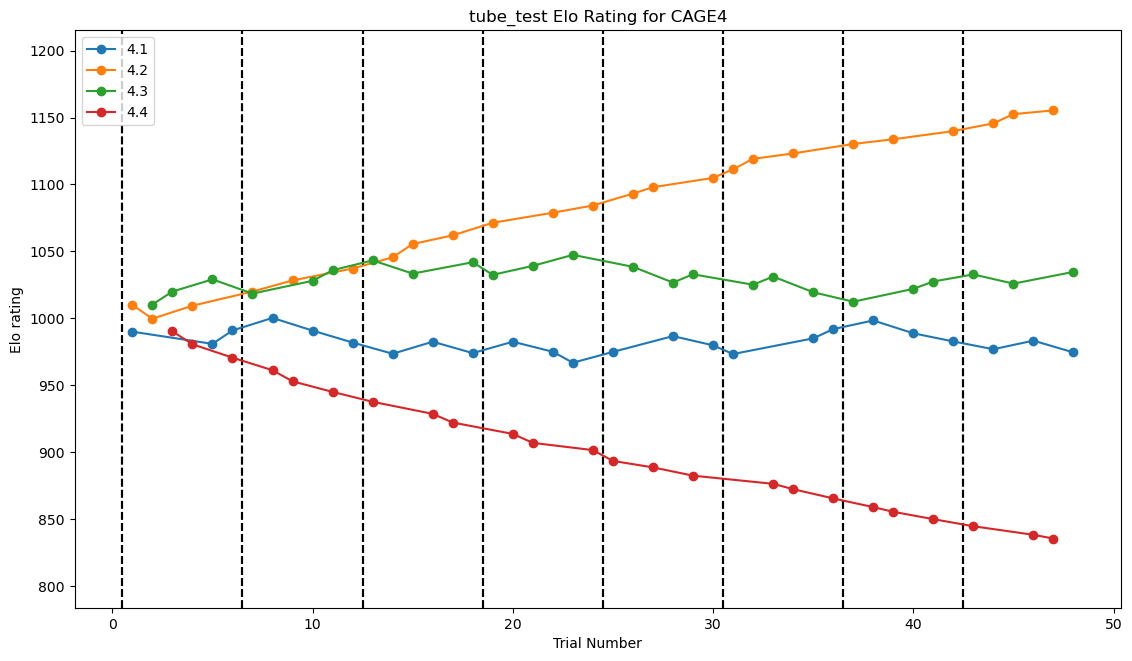

CAGE5


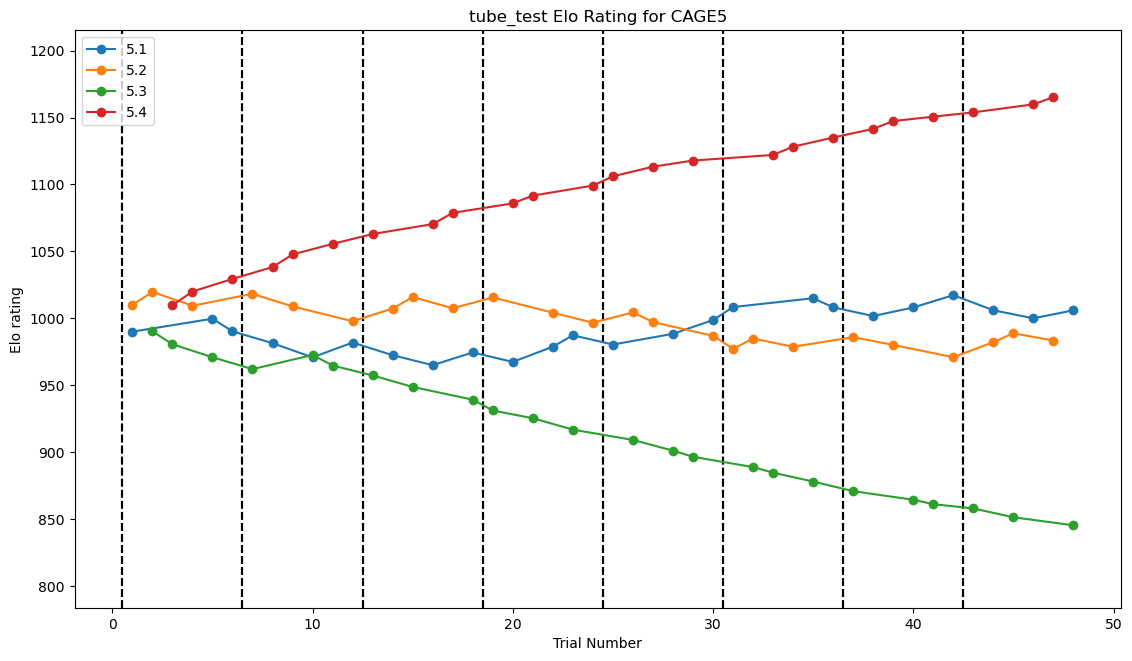

CAGE6


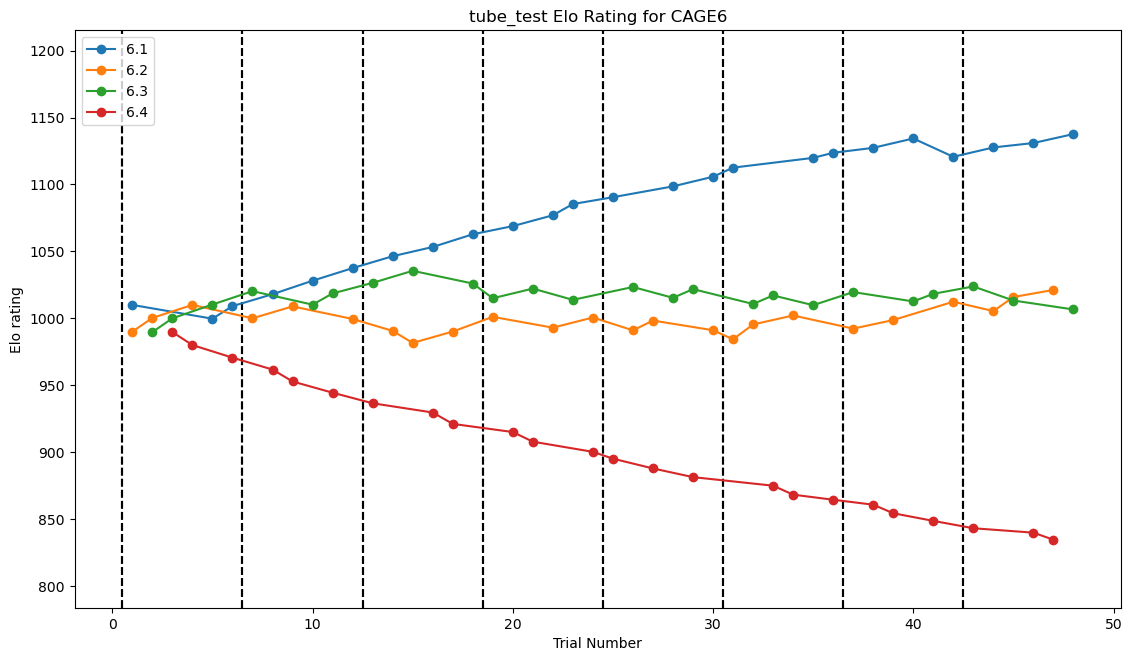

In [60]:
# Getting the highest and lowest Elo rating for cutoffs of the Y-axis
max_elo_rating = all_sheet_elo_scord_dataframe_combined["updated_elo_rating"].max()
min_elo_rating = all_sheet_elo_scord_dataframe_combined["updated_elo_rating"].min()

plt.rcParams["figure.figsize"] = (13.5,7.5)
# Making a plot for each sheet
for key, value in sheet_name_to_everything.items():
    # Setting the size of the figure
    plt.rcParams["figure.figsize"] = (13.5,7.5)
    print(key)
    elo_rating_dataframe = value["elo_rating_dataframe"]
    # Using a new figure template for each sheet
    fig, ax = plt.subplots()        
        
    try:
        # Drawing vertical lines that represent when each session begins
        # Based on when a row has a different session than the previous row
        for index, row in elo_rating_dataframe[elo_rating_dataframe['session_number_difference'].astype(bool)].iterrows():
            # Offsetting by 0.5 to avoid drawing the line on the dot
            # Drawing the lines a little above the max and a little below the minimum
            plt.vlines(x=[row["total_match_number"] - 0.5], ymin=min_elo_rating-50, ymax=max_elo_rating+50, colors='black', linestyle='dashed')
    except:
        print("WARNING: {} does not have a column for session divider".format(key))
        warnings.warn("Look at warning from above or below")
            
    # Drawing a line for each subject
    for subject in sorted(elo_rating_dataframe["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_dataframe = elo_rating_dataframe[elo_rating_dataframe["subject_id"] == subject]
        # Making the current match number the X-Axis
        plt.plot(subject_dataframe["total_match_number"], subject_dataframe["updated_elo_rating"], '-o', label=subject)

    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo rating")
    # Formattnig Cohort and Experiment Name so that it's more readable with spacing and capitalization
    
    ax.set_title("{} Elo Rating for {}".format(PROTOCOL_NAME, key))
    
    # To show the legend
    ax.legend(loc="upper left")
    # Setting the values of the Y-axis
    plt.ylim(min_elo_rating-50, max_elo_rating+50) 
    # Saving the plot
    file_name_parts_separated = [PREFIX_NAME, key, earliest_date, latest_date]
    file_name_parts_combined = "_".join([part for part in file_name_parts_separated if part])
    
    file_name_full = "elo_rating_{}.png".format(file_name_parts_combined)
    # Removing all the spaces and replacing them with underscores
    file_name_full = "_".join(file_name_full.split(" "))
    plt.savefig(os.path.join(plot_output_directory, file_name_full))
    # Showing the plots
    plt.show()

# Saving the Dataframes

- Creating a subfolder to put the Elo rating Spreadsheets

In [61]:
elo_rating_spreadsheet_output_directory = os.path.join(".", "proc", "elo_rating_spread_sheets", "{}".format(PROTOCOL_NAME))

In [62]:
elo_rating_spreadsheet_output_directory

'./proc/elo_rating_spread_sheets/tube_test'

In [63]:
os.makedirs(elo_rating_spreadsheet_output_directory, exist_ok=True)

- Saving the dataframes to a file

In [64]:
file_name_parts_separated = [all_cages_string, PREFIX_NAME, earliest_date, latest_date]
file_name_parts_combined = "_".join([part for part in file_name_parts_separated if part])

file_name_full = "{}_elo-rating-history.csv".format(file_name_parts_combined)
print(file_name_full)
all_sheet_elo_scord_dataframe_combined.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name_full))

cages-1-2-3-4-5-6_tt_2022-09-06_2022-09-27_elo-rating-history.csv


In [65]:
file_name_full = "{}_final-elo-rating.csv".format(file_name_parts_combined)
print(file_name_full)
id_to_final_elo_rating_df.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name_full))

cages-1-2-3-4-5-6_tt_2022-09-06_2022-09-27_final-elo-rating.csv


# Seeing which subject is the dominant or submissive

- Grouping all the rows with the same pair

In [66]:
all_processed_behavior_recording_list = []
for key, value in sheet_name_to_everything.items():
    all_processed_behavior_recording_list.append(value["processed_behavior_recording_dataframe"])
    

- Combining all the dataframes from all the cages

In [67]:
all_processed_behavior_recording_df = pd.concat(all_processed_behavior_recording_list)

In [68]:
all_processed_behavior_recording_df.head()

,runner,date,match,winner,loser,notes,sheet_name,session_number_difference
0,Jocelyn,2022-09-06,1.1vs1.2,1.1,1.2,NaN,CAGE1,NaN
1,Jocelyn,2022-09-06,1.2vs1.3,1.2,1.3,NaN,CAGE1,0.0
2,Jocelyn,2022-09-06,1.3vs1.4,1.4,1.3,NaN,CAGE1,0.0
3,Jocelyn,2022-09-06,1.1vs1.3,1.1,1.3,did not realize mouse 3 had 3 matches in a row...,CAGE1,0.0
4,Jocelyn,2022-09-06,1.2vs1.4,1.2,1.4,did not realize mouse 3 had 3 matches in a row...,CAGE1,0.0


- Getting a tuple of the animal IDs to be able to group

# Note: This assumes that all the animal IDs are different across cages and that all IDs are numbers. i.e. there are no duplicate IDs in different cages.

In [69]:
# Getting the animal IDs from the Match string
# i.e. Getting all the floats and removing all spaces
# Sorting so that the animal IDs are always in the same order
all_processed_behavior_recording_df["animal_id"] =  all_processed_behavior_recording_df["match"].apply(lambda x: sorted([subject_id.lower().strip() for subject_id in re.findall(r"[-+]?(?:\d*\.\d+|\d+)", x)]))


In [70]:
# Making a tuple out of the list
# Tuples are used because lists are mutable and can't be grouped with
all_processed_behavior_recording_df["tuple_animal_id"] = all_processed_behavior_recording_df["animal_id"].apply(lambda x: tuple(x))

In [71]:
all_processed_behavior_recording_df.head()

,runner,date,match,winner,loser,notes,sheet_name,session_number_difference,animal_id,tuple_animal_id
0,Jocelyn,2022-09-06,1.1vs1.2,1.1,1.2,NaN,CAGE1,NaN,"[1.1, 1.2]","(1.1, 1.2)"
1,Jocelyn,2022-09-06,1.2vs1.3,1.2,1.3,NaN,CAGE1,0.0,"[1.2, 1.3]","(1.2, 1.3)"
2,Jocelyn,2022-09-06,1.3vs1.4,1.4,1.3,NaN,CAGE1,0.0,"[1.3, 1.4]","(1.3, 1.4)"
3,Jocelyn,2022-09-06,1.1vs1.3,1.1,1.3,did not realize mouse 3 had 3 matches in a row...,CAGE1,0.0,"[1.1, 1.3]","(1.1, 1.3)"
4,Jocelyn,2022-09-06,1.2vs1.4,1.2,1.4,did not realize mouse 3 had 3 matches in a row...,CAGE1,0.0,"[1.2, 1.4]","(1.2, 1.4)"


- Removing columns that would be unnecessary for the pairings

In [72]:
all_processed_behavior_recording_df.columns

Index(['runner', 'date', 'match', 'winner', 'loser', 'notes', 'sheet_name',
       'session_number_difference', 'animal_id', 'tuple_animal_id'],
      dtype='object')

In [73]:
# Getting only the columns that we need
all_processed_behavior_recording_df = all_processed_behavior_recording_df[['date', 'winner', 'loser', 'animal_id', 'tuple_animal_id', "sheet_name"]]

In [74]:
all_processed_behavior_recording_df.head()

,date,winner,loser,animal_id,tuple_animal_id,sheet_name
0,2022-09-06,1.1,1.2,"[1.1, 1.2]","(1.1, 1.2)",CAGE1
1,2022-09-06,1.2,1.3,"[1.2, 1.3]","(1.2, 1.3)",CAGE1
2,2022-09-06,1.4,1.3,"[1.3, 1.4]","(1.3, 1.4)",CAGE1
3,2022-09-06,1.1,1.3,"[1.1, 1.3]","(1.1, 1.3)",CAGE1
4,2022-09-06,1.2,1.4,"[1.2, 1.4]","(1.2, 1.4)",CAGE1


- Getting the ID of the winner and the loser for each pair with each match

In [75]:
all_wins_per_pair = all_processed_behavior_recording_df.groupby("tuple_animal_id")['winner'].apply(list)
all_loses_per_pair = all_processed_behavior_recording_df.groupby("tuple_animal_id")['loser'].apply(list)

In [76]:
all_wins_per_pair[:5]

tuple_animal_id
(1.1, 1.2)    [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]
(1.1, 1.3)    [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]
(1.1, 1.4)    [1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]
(1.2, 1.3)    [1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]
(1.2, 1.4)    [1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]
Name: winner, dtype: object

- Making a dataframe of all the winner IDs and all the loser IDs for a given pair

In [77]:
all_competition_per_pair_df = pd.concat([all_wins_per_pair, all_loses_per_pair], axis=1).reset_index()

In [78]:
all_competition_per_pair_df = all_competition_per_pair_df.rename(columns={k: PREFIX_NAME + "_" + k for k in all_competition_per_pair_df.columns})

In [79]:
all_competition_per_pair_df

,tt_tuple_animal_id,tt_winner,tt_loser
0,"(1.1, 1.2)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]"
1,"(1.1, 1.3)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]"
2,"(1.1, 1.4)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]"
3,"(1.2, 1.3)","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]"
4,"(1.2, 1.4)","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]"
5,"(1.3, 1.4)","[1.4, 1.4, 1.4, 1.3, 1.4, 1.3, 1.4, 1.3]","[1.3, 1.3, 1.3, 1.4, 1.3, 1.4, 1.3, 1.4]"
6,"(2.1, 2.2)","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.2]","[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.1]"
7,"(2.1, 2.3)","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.3]","[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.1]"
8,"(2.1, 2.4)","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1]","[2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4]"
9,"(2.2, 2.3)","[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3]","[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2]"


- Adding the cage information

In [80]:
# Getting the cage number for each pair
dropped_duplicate_all_processed_behavior_recording_df = all_processed_behavior_recording_df[["tuple_animal_id"]].drop_duplicates()

In [81]:
dropped_duplicate_all_processed_behavior_recording_df.head()

,tuple_animal_id
0,"(1.1, 1.2)"
1,"(1.2, 1.3)"
2,"(1.3, 1.4)"
3,"(1.1, 1.3)"
4,"(1.2, 1.4)"


- Calculating the overall winner and loser. Also seeing if there is signficant difference in the number of wins to see if one is dominant over the other

In [82]:
all_competition_per_pair_df["{}_averaged_winner".format(PREFIX_NAME)] = all_competition_per_pair_df["{}_winner".format(PREFIX_NAME)].apply(lambda x: Counter(x).most_common(1)[0][0])
all_competition_per_pair_df["{}_averaged_loser".format(PREFIX_NAME)] = all_competition_per_pair_df["{}_loser".format(PREFIX_NAME)].apply(lambda x: Counter(x).most_common(1)[0][0])
all_competition_per_pair_df["{}_winner_count".format(PREFIX_NAME)] = all_competition_per_pair_df.apply(lambda x: x["{}_winner".format(PREFIX_NAME)].count(x["{}_averaged_winner".format(PREFIX_NAME)]), axis=1)
all_competition_per_pair_df["{}_loser_count".format(PREFIX_NAME)] = all_competition_per_pair_df.apply(lambda x: x["{}_winner".format(PREFIX_NAME)].count(x["{}_averaged_loser".format(PREFIX_NAME)]), axis=1)
all_competition_per_pair_df["{}_count_difference".format(PREFIX_NAME)] = all_competition_per_pair_df["{}_winner_count".format(PREFIX_NAME)] - all_competition_per_pair_df["{}_loser_count".format(PREFIX_NAME)]
all_competition_per_pair_df["{}_match_count".format(PREFIX_NAME)] = all_competition_per_pair_df["{}_winner".format(PREFIX_NAME)].apply(lambda x: len(x))
all_competition_per_pair_df["{}_percent_win".format(PREFIX_NAME)] = all_competition_per_pair_df.apply(lambda x: x["{}_winner_count".format(PREFIX_NAME)] / x["{}_match_count".format(PREFIX_NAME)], axis=1)
all_competition_per_pair_df["{}_percentage_tie".format(PREFIX_NAME)] = all_competition_per_pair_df["{}_percent_win".format(PREFIX_NAME)].apply(lambda x: True if x < 0.75 else False)

In [83]:
all_competition_per_pair_df

,tt_tuple_animal_id,tt_winner,tt_loser,tt_averaged_winner,tt_averaged_loser,tt_winner_count,tt_loser_count,tt_count_difference,tt_match_count,tt_percent_win,tt_percentage_tie
0,"(1.1, 1.2)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]",1.1,1.2,8,0,8,8,1.000,False
1,"(1.1, 1.3)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]",1.1,1.3,8,0,8,8,1.000,False
2,"(1.1, 1.4)","[1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1]","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]",1.1,1.4,8,0,8,8,1.000,False
3,"(1.2, 1.3)","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]","[1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3, 1.3]",1.2,1.3,8,0,8,8,1.000,False
4,"(1.2, 1.4)","[1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2]","[1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4]",1.2,1.4,8,0,8,8,1.000,False
5,"(1.3, 1.4)","[1.4, 1.4, 1.4, 1.3, 1.4, 1.3, 1.4, 1.3]","[1.3, 1.3, 1.3, 1.4, 1.3, 1.4, 1.3, 1.4]",1.4,1.3,5,3,2,8,0.625,True
6,"(2.1, 2.2)","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.2]","[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.1]",2.1,2.2,7,1,6,8,0.875,False
7,"(2.1, 2.3)","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.3]","[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.1]",2.1,2.3,7,1,6,8,0.875,False
8,"(2.1, 2.4)","[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1]","[2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4]",2.1,2.4,8,0,8,8,1.000,False
9,"(2.2, 2.3)","[2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3]","[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2]",2.3,2.2,8,0,8,8,1.000,False


- Saving the competiton pair results dataframe to a file

In [84]:
file_name = "{}_grouped_by_pairs_cage_{}_date_{}_{}.csv".format(PREFIX_NAME, all_cages_string, earliest_date, latest_date)


In [85]:
elo_rating_spreadsheet_output_directory

'./proc/elo_rating_spread_sheets/tube_test'

In [86]:
file_name

'tt_grouped_by_pairs_cage_cages-1-2-3-4-5-6_date_2022-09-06_2022-09-27.csv'

In [87]:
all_competition_per_pair_df.to_csv(os.path.join(elo_rating_spreadsheet_output_directory, file_name))